# CNN Model to predict seamounts 

## Lib import and definitions stage

In [14]:
import os
import cv2
from collections import Counter
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# prevent CUDA usage Warnings
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Parameters
image_folder = "./data_241208"  # Root directory of the dataset
output_folder = "temp_processed_data_241208"  # Temporary folder for cropped images
image_size = (128, 128)  # Image dimensions for the model
crop_pixels = 70  # Pixels to crop from each border

# Categories
categories = ["with_seamount_manual1", "without_seamounts_manual1"]  # Subfolders in `image_folder`

## Image preparation stage

Read all images from source folder, remove border and shrink images. 
Only need to run this stage if images in source folder has changed.

In [12]:
# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Function to crop borders from an image
def crop_fixed_border(image, crop_pixels=5):
    height, width, _ = image.shape
    if height > crop_pixels * 2 and width > crop_pixels * 2:
        cropped_image = image[crop_pixels:height-crop_pixels, crop_pixels:width-crop_pixels]
        return cropped_image
    else:
        return image  # Return original image if cropping not possible

# Preprocess images (cropping and resizing)
print("Preprocessing images...")
for category in categories:
    category_folder = os.path.join(image_folder, category)
    output_category_folder = os.path.join(output_folder, category)
    os.makedirs(output_category_folder, exist_ok=True)
    
    for file_name in os.listdir(category_folder):
        image_path = os.path.join(category_folder, file_name)
        output_path = os.path.join(output_category_folder, file_name)
        try:
            image = cv2.imread(image_path)
            if image is not None:
                cropped_image = crop_fixed_border(image, crop_pixels)
                resized_image = cv2.resize(cropped_image, image_size)
                cv2.imwrite(output_path, resized_image)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

print("Preprocessing complete.")

Preprocessing images...
Preprocessing complete.


## Load the datasets, split in train, val and test sets and nomalize values
Load into data and labels

In [10]:
# Load processed dataset
def load_data(directory, categories):
    data, labels = [], []
    for label, category in enumerate(categories):
        category_folder = os.path.join(directory, category)
        for file_name in os.listdir(category_folder):
            file_path = os.path.join(category_folder, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                data.append(image)
                labels.append(label)
    return np.array(data), np.array(labels)

data, labels = load_data(output_folder, categories)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print("Datasets load, normalized and splitted")

def show_label_distribution(labels, dataset_name):
    label_counts = Counter(labels)
    print(f"Label distribution for {dataset_name} with {len(labels)} Images:")
    for label, count in label_counts.items():
        print(f"  Labels {label}: {count}")

# show some basic stats about the datasets
show_label_distribution(y_train, "Training set")
show_label_distribution(y_val, "Validation set")
show_label_distribution(y_test, "Test set")

Datasets load, normalized and splitted
Label distribution for Training set with 420 Images:
  Labels 0: 202
  Labels 1: 218
Label distribution for Validation set with 90 Images:
  Labels 0: 50
  Labels 1: 40
Label distribution for Test set with 90 Images:
  Labels 0: 48
  Labels 1: 42


## Define the CNN Model

Define and show structure

In [10]:
# Define the CNN model
model = Sequential([
    Input(shape=(image_size[0], image_size[1], 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# show architecture
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
# learn parameter
batch_size = 16
epochs = 50

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print(classification_report(y_test, y_pred, target_names=categories))


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.4729 - loss: 0.9205 - val_accuracy: 0.5556 - val_loss: 0.6841
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.4826 - loss: 0.6972 - val_accuracy: 0.5556 - val_loss: 0.6846
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.4881 - loss: 0.7069 - val_accuracy: 0.6444 - val_loss: 0.6573
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.6878 - loss: 0.6432 - val_accuracy: 0.7556 - val_loss: 0.5419
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.6928 - loss: 0.6067 - val_accuracy: 0.7778 - val_loss: 0.4873
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7699 - loss: 0.5188 - val_accuracy: 0.7889 - val_loss: 0.4663
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.8370 - loss: 0.3842 - val_accuracy: 0.7444 - val_loss: 0.5132
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.8267 - loss: 0.3703 - val_accuracy: 0.

## Save model
Optional save your model to compare and access models later
TODO: think about to better store different learning paramater

In [17]:
# Save the model
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"seamount_classifier_model_v1_0-{current_datetime}.keras"

model.save(model_filename)
print(f"Model saved under {model_filename}")

Model saved under seamount_classifier_model_v1_0-2024-12-16 20:32:12.keras


## Re-Load a saved model

In [15]:
# Load the model
model_filename = "seamount_classifier_model_v1_0-2024-12-16_20-32-12.keras"

model = load_model(model_filename)
print(f"Model under filename {model_filename} successfull loaded")

2024-12-17 20:35:23.848059: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model under filename seamount_classifier_model_v1_0-2024-12-16_20-32-12.keras successfull loaded


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Show diagram of learing process

NameError: name 'history' is not defined

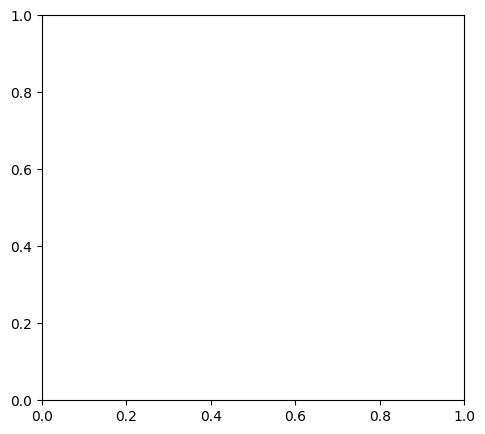

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Plotting the training/validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Compute confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test).flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


## Show some details about the non-matches

Found 9 False Negative images - Displaying sample of up to 5 images


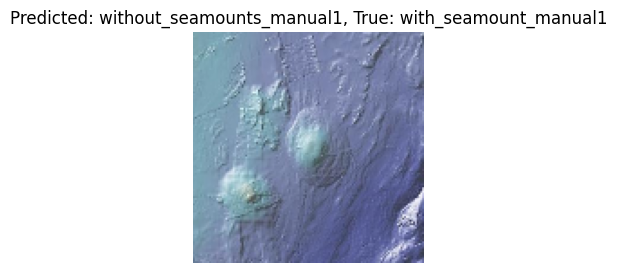

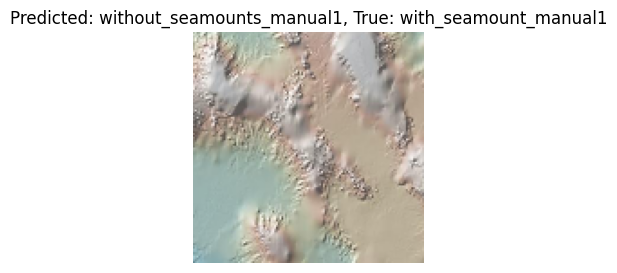

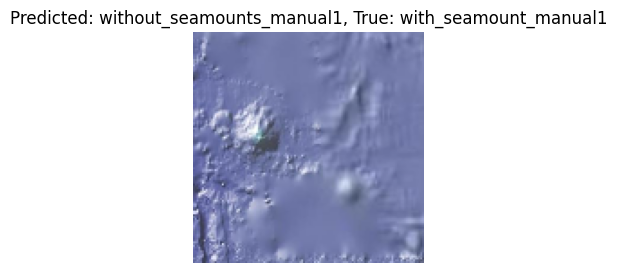

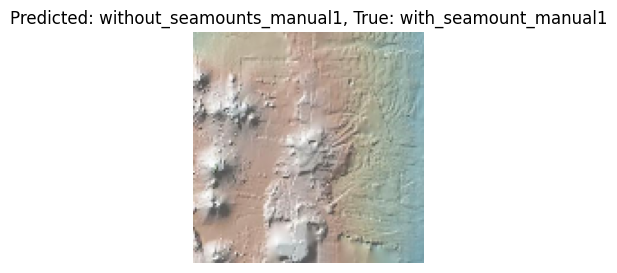

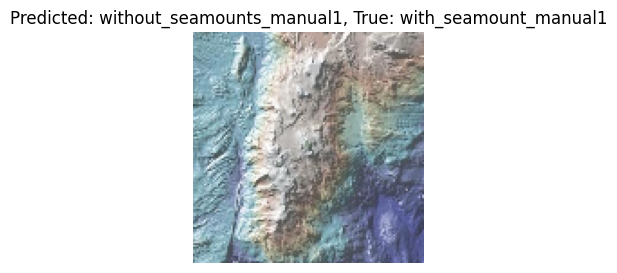

Found 5 False Positive images -  Displaying sample of up to 5 images


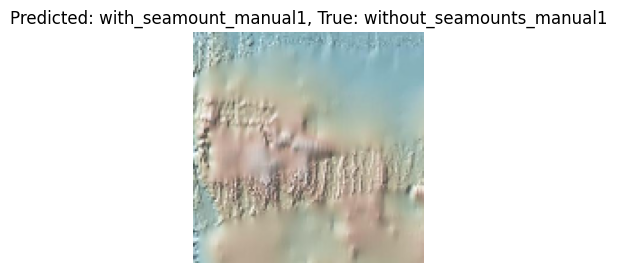

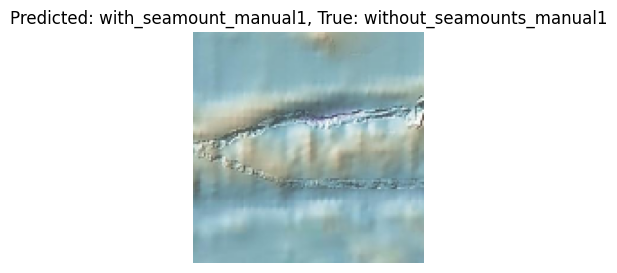

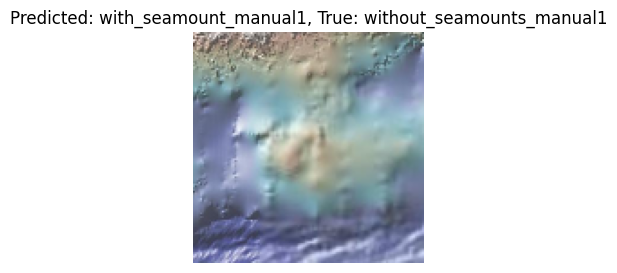

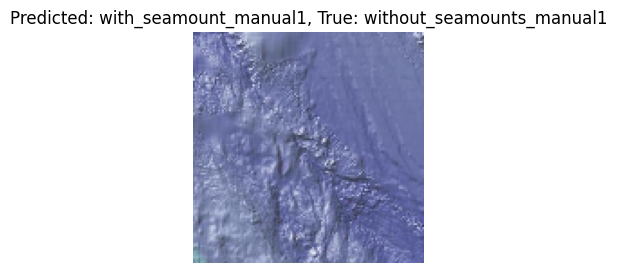

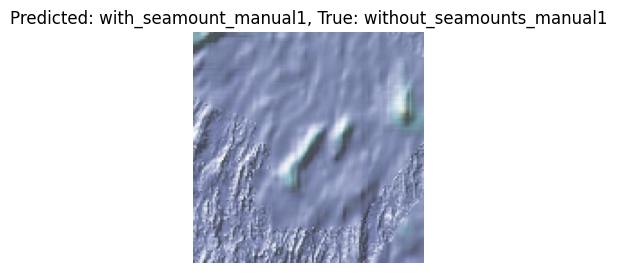

In [19]:
import matplotlib.pyplot as plt
import cv2

# Get the indices of false positives and false negatives
false_positives = []
false_negatives = []

# Loop through the test set to find false positives and false negatives
for i in range(len(y_test)):
    if y_pred[i] == 1 and y_test[i] == 0:  # Predicted 'with_seamounts', but true label is 'without_seamounts' (False Positive)
        false_positives.append(i)
    elif y_pred[i] == 0 and y_test[i] == 1:  # Predicted 'without_seamounts', but true label is 'with_seamounts' (False Negative)
        false_negatives.append(i)

# Display false positives
print(f"Found {len(false_positives)} False Negative images - Displaying sample of up to 5 images")
for i in range(min(5, len(false_positives))):  # Show up to 5 false positives
    index = false_positives[i]
    image = X_test[index] * 255.0  # Rescale back to original pixel values
    image = image.astype(np.uint8)
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {categories[1]}, True: {categories[0]}")
    plt.axis('off')
    plt.show()

# Display false negatives
print(f"Found {len(false_negatives)} False Positive images -  Displaying sample of up to 5 images")
for i in range(min(5, len(false_negatives))):  # Show up to 5 false negatives
    index = false_negatives[i]
    image = X_test[index] * 255.0  # Rescale back to original pixel values
    image = image.astype(np.uint8)
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {categories[0]}, True: {categories[1]}")
    plt.axis('off')
    plt.show()